# End-to-End Time Series Forecasting Workshop

## A Complete Workflow from EDA to Model Comparison

This notebook demonstrates a complete time series forecasting pipeline:

1. **Exploratory Data Analysis** - visualization, decomposition, seasonality
2. **Simple & Statistical Models** - baseline methods and exponential smoothing
3. **Global ML Models** - LightGBM and Linear Regression with feature engineering
4. **Rigorous Evaluation** - 5-fold cross-validation with MASE and RMSSE metrics
5. **Model Comparison** - comprehensive performance analysis

Let's get started!

## 1. Setup and Imports

In [22]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Statistical forecasting
from statsforecast import StatsForecast
from statsforecast.models import (
    Naive, 
    SeasonalNaive, 
    WindowAverage, 
    SeasonalWindowAverage,
    AutoETS
)

# ML forecasting
from mlforecast import MLForecast
from mlforecast.target_transforms import LocalStandardScaler, LocalMinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb

# Plotting style
plt.style.use('ggplot')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Load Data

We'll use the **top 50 food items** dataset from the M5 competition.

In [23]:
# Load the data
data_path = '/home/filtheo/Cloud-for-AI/workshop_ml_2025/data/converted_df_2.csv'
df = pd.read_csv(data_path, parse_dates=['date'])

print(f"Dataset shape: {df.shape}")
print(f"Number of items: {df['unique_id'].nunique()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total days: {df['date'].nunique()}")
print(f"\nFirst few rows:")
df.head(10)

Dataset shape: (60500, 3)
Number of items: 50
Date range: 2013-01-01 00:00:00 to 2016-04-24 00:00:00
Total days: 1210

First few rows:


,unique_id,date,y
0,FOODS_1_085,2013-01-01,89
1,FOODS_1_218,2013-01-01,176
2,FOODS_2_128,2013-01-01,94
3,FOODS_2_197,2013-01-01,68
4,FOODS_2_276,2013-01-01,33
5,FOODS_2_360,2013-01-01,159
6,FOODS_3_007,2013-01-01,121
7,FOODS_3_030,2013-01-01,132
8,FOODS_3_080,2013-01-01,112
9,FOODS_3_090,2013-01-01,460


## 3. Exploratory Data Analysis

### 3.1 Visualize Time Series

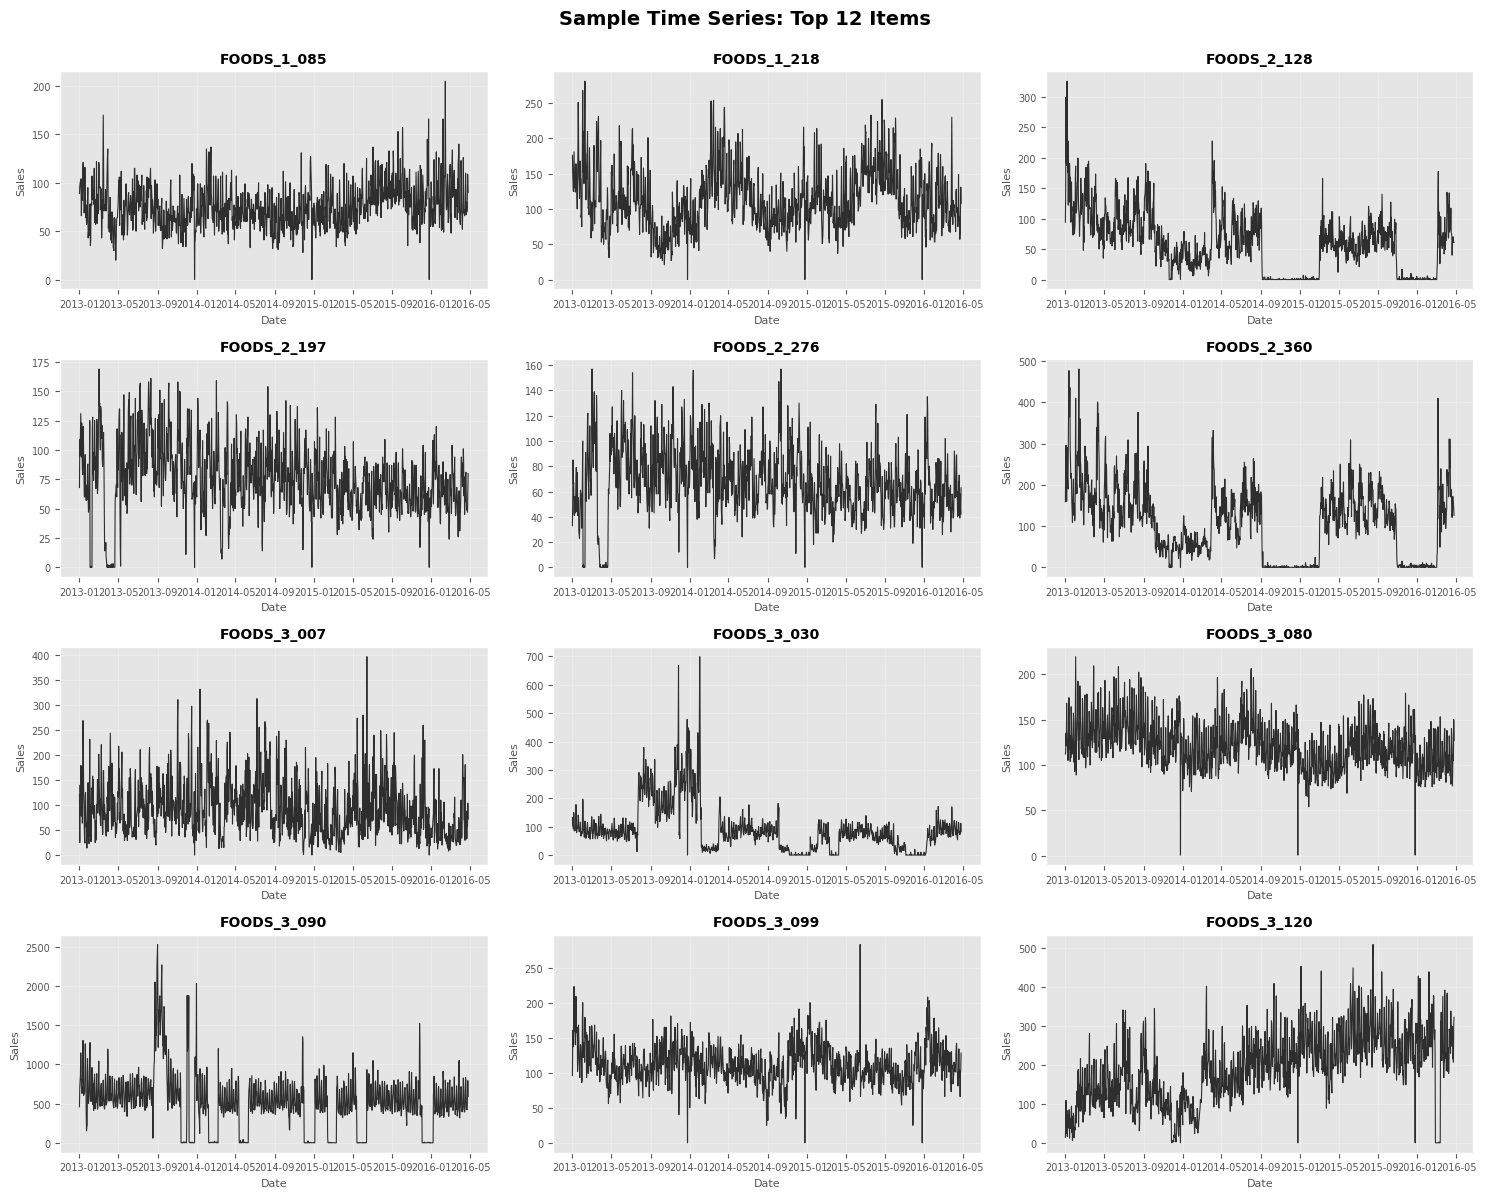


🔍 Observations:
- Different items have different sales levels
- Clear patterns and seasonality visible
- Some items show trends over time


In [24]:
# Plot a sample of 12 series
items = df['unique_id'].unique()[:12]

fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, item in enumerate(items):
    item_data = df[df['unique_id'] == item].sort_values('date')
    
    axes[idx].plot(item_data['date'], item_data['y'], 
                   color='black', linewidth=0.8, alpha=0.8)
    axes[idx].set_title(f'{item}', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=8)
    axes[idx].set_ylabel('Sales', fontsize=8)
    axes[idx].tick_params(labelsize=7)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Sample Time Series: Top 12 Items', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n🔍 Observations:")
print("- Different items have different sales levels")
print("- Clear patterns and seasonality visible")
print("- Some items show trends over time")

### 3.2 Time Series Decomposition

Let's decompose a sample series to see its components: **Trend**, **Seasonality**, and **Residual**.

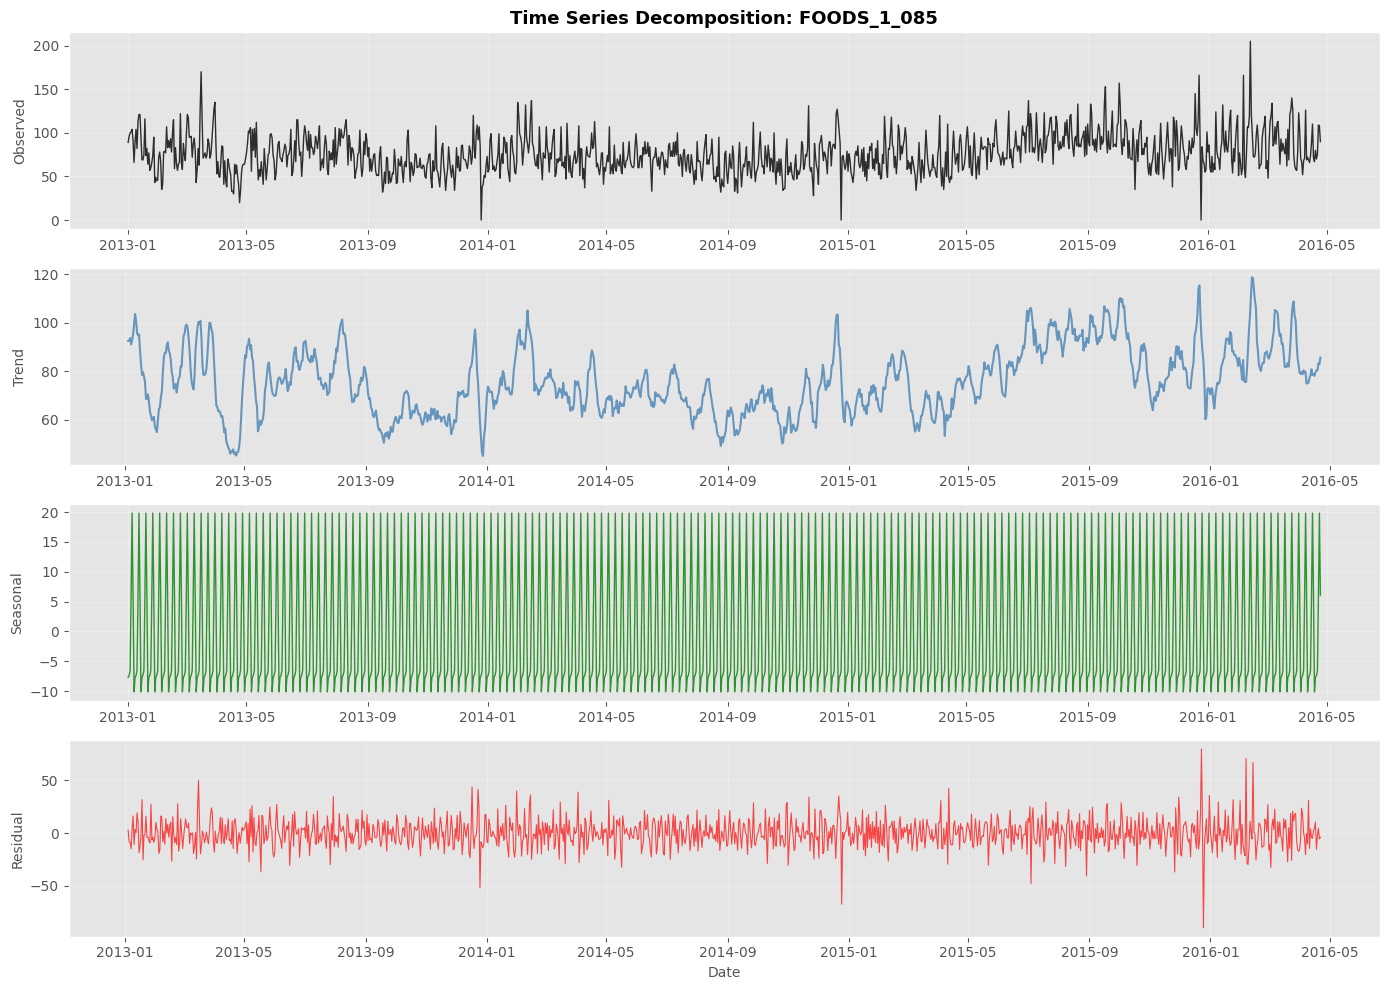

In [25]:
# Decompose a sample item
sample_item = items[0]
item_data = df[df['unique_id'] == sample_item].sort_values('date').set_index('date')

# Perform seasonal decomposition (period=7 for weekly seasonality)
decomposition = seasonal_decompose(item_data['y'], model='additive', period=7)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# Observed
axes[0].plot(decomposition.observed, color='black', linewidth=1, alpha=0.8)
axes[0].set_ylabel('Observed', fontsize=10)
axes[0].set_title(f'Time Series Decomposition: {sample_item}', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Trend
axes[1].plot(decomposition.trend, color='steelblue', linewidth=1.5, alpha=0.8)
axes[1].set_ylabel('Trend', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Seasonal
axes[2].plot(decomposition.seasonal, color='green', linewidth=1, alpha=0.8)
axes[2].set_ylabel('Seasonal', fontsize=10)
axes[2].grid(True, alpha=0.3)

# Residual
axes[3].plot(decomposition.resid, color='red', linewidth=0.8, alpha=0.7)
axes[3].set_ylabel('Residual', fontsize=10)
axes[3].set_xlabel('Date', fontsize=10)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3 Aggregated Seasonality Strength

**Seasonality Strength Formula:**

$$\text{Strength} = 1 - \frac{\text{Var(Residual)}}{\text{Var(Seasonal + Residual)}}$$

- Value close to **1** = Strong seasonality
- Value close to **0** = Weak seasonality

Seasonality Strength Statistics:
Mean:   0.336
Median: 0.363
Std:    0.174
Min:    0.046
Max:    0.710


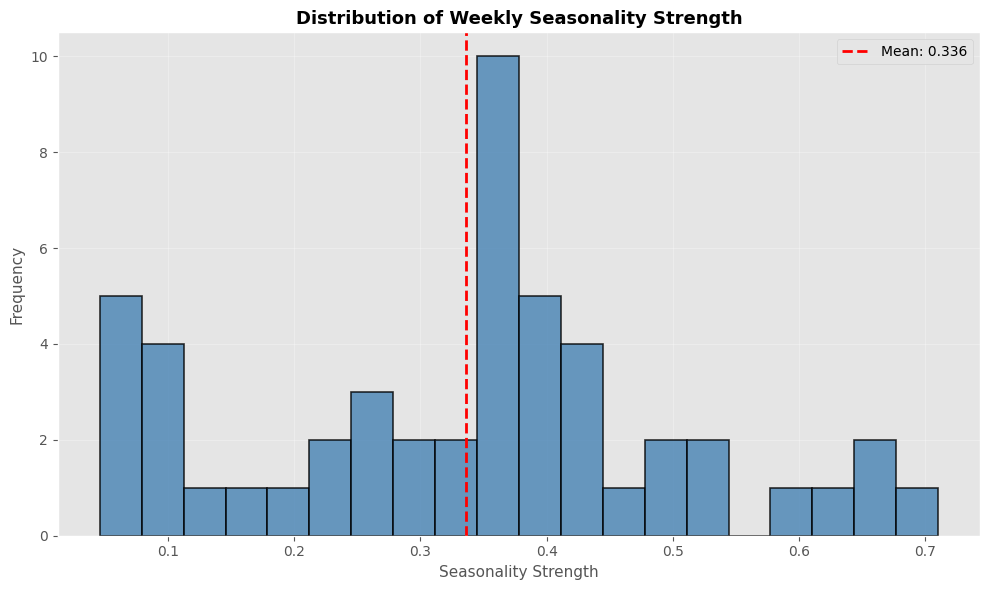

In [26]:
# Calculate seasonality strength for all items
seasonality_strength = {}

for item in df['unique_id'].unique():
    item_data = df[df['unique_id'] == item].sort_values('date').set_index('date')
    
    try:
        decomp = seasonal_decompose(item_data['y'], model='additive', period=7)
        
        # Calculate strength
        seasonal_var = np.var(decomp.seasonal.dropna())
        resid_var = np.var(decomp.resid.dropna())
        
        strength = 1 - (resid_var / (seasonal_var + resid_var))
        seasonality_strength[item] = strength
    except:
        seasonality_strength[item] = np.nan

# Convert to DataFrame
strength_df = pd.DataFrame(list(seasonality_strength.items()), 
                           columns=['Item', 'Seasonality_Strength'])
strength_df = strength_df.dropna().sort_values('Seasonality_Strength', ascending=False)

print("Seasonality Strength Statistics:")
print("=" * 50)
print(f"Mean:   {strength_df['Seasonality_Strength'].mean():.3f}")
print(f"Median: {strength_df['Seasonality_Strength'].median():.3f}")
print(f"Std:    {strength_df['Seasonality_Strength'].std():.3f}")
print(f"Min:    {strength_df['Seasonality_Strength'].min():.3f}")
print(f"Max:    {strength_df['Seasonality_Strength'].max():.3f}")

# Plot histogram
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(strength_df['Seasonality_Strength'], bins=20, color='steelblue', 
        alpha=0.8, edgecolor='black', linewidth=1.2)
ax.axvline(x=strength_df['Seasonality_Strength'].mean(), color='red', 
           linestyle='--', linewidth=2, label=f"Mean: {strength_df['Seasonality_Strength'].mean():.3f}")
ax.set_xlabel('Seasonality Strength', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Distribution of Weekly Seasonality Strength', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Define Custom Evaluation Metrics

We'll use two scaled metrics for model evaluation:

### 4.1 MASE (Mean Absolute Scaled Error)

$$\text{MASE} = \frac{\text{MAE}}{\text{MAE}_{\text{naive}}}$$

where $\text{MAE}_{\text{naive}} = \frac{1}{n-1}\sum_{t=2}^{n}|y_t - y_{t-1}|$

### 4.2 RMSSE (Root Mean Squared Scaled Error)

$$\text{RMSSE} = \sqrt{\frac{\text{MSE}}{\text{MSE}_{\text{naive}}}}$$

where $\text{MSE}_{\text{naive}} = \frac{1}{n-1}\sum_{t=2}^{n}(y_t - y_{t-1})^2$

Both metrics are **scale-independent**, allowing comparison across different series.

In [27]:
def calculate_mase(y_true, y_pred, y_train, seasonality=1):
    """
    Calculate Mean Absolute Scaled Error (MASE).
    
    Parameters:
    -----------
    y_true : array-like
        True values
    y_pred : array-like
        Predicted values
    y_train : array-like
        Training data for scaling
    seasonality : int
        Seasonal period (1 for non-seasonal)
    
    Returns:
    --------
    float : MASE value
    """
    # Calculate forecast error
    mae_forecast = np.mean(np.abs(y_true - y_pred))
    
    # Calculate naive forecast MAE on training data
    mae_naive = np.mean(np.abs(np.diff(y_train, n=seasonality)))
    
    # Avoid division by zero
    if mae_naive == 0:
        return np.nan
    
    return mae_forecast / mae_naive


def calculate_rmsse(y_true, y_pred, y_train, seasonality=1):
    """
    Calculate Root Mean Squared Scaled Error (RMSSE).
    
    Parameters:
    -----------
    y_true : array-like
        True values
    y_pred : array-like
        Predicted values
    y_train : array-like
        Training data for scaling
    seasonality : int
        Seasonal period (1 for non-seasonal)
    
    Returns:
    --------
    float : RMSSE value
    """
    # Calculate forecast MSE
    mse_forecast = np.mean((y_true - y_pred) ** 2)
    
    # Calculate naive forecast MSE on training data
    mse_naive = np.mean(np.diff(y_train, n=seasonality) ** 2)
    
    # Avoid division by zero
    if mse_naive == 0:
        return np.nan
    
    return np.sqrt(mse_forecast / mse_naive)


print("✅ Custom metrics defined: MASE and RMSSE")

✅ Custom metrics defined: MASE and RMSSE


## 5. Simple and Statistical Models with StatsForecast

We'll evaluate:
- **Naive**: Last value repeated
- **SeasonalNaive**: Same season from last cycle
- **WindowAverage**: Moving average
- **SeasonalWindowAverage**: Seasonal moving average
- **AutoETS**: Exponential smoothing with automatic component selection

Using **5-fold cross-validation**.

In [ ]:
# Prepare data for StatsForecast (rename 'date' to 'ds')
df_sf = df.rename(columns={'date': 'ds'})

# Define models
models = [
    Naive(),
    SeasonalNaive(season_length=7),
    WindowAverage(window_size=7),
    SeasonalWindowAverage(season_length=7, window_size=2),
    AutoETS(season_length=7)
]

# Initialize StatsForecast
sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=-1
)

# Perform 5-fold cross-validation
print("Running 5-fold cross-validation for statistical models...")
cv_results_sf = sf.cross_validation(
    df=df_sf,
    h=14,           # Forecast horizon
    step_size=14,   # Step between windows
    n_windows=5     # Number of folds
)

print("✅ Cross-validation complete!")
print(f"\nCV Results shape: {cv_results_sf.shape}")
cv_results_sf.head()

Running 5-fold cross-validation for statistical models...


### 5.1 Calculate MASE and RMSSE for Statistical Models

In [ ]:
# Model names
model_names = ['Naive', 'SeasonalNaive', 'WindowAverage', 'SeasWA', 'AutoETS']

# Calculate metrics for each model and item
metrics_sf = {'Model': [], 'MASE': [], 'RMSSE': []}

for model_name in model_names:

    mase_values = []
    rmsse_values = []
    
    for item in df_sf['unique_id'].unique():
        # Get CV results for this item
        item_cv = cv_results_sf[cv_results_sf['unique_id'] == item]
        
        if len(item_cv) == 0 or model_name not in item_cv.columns:
            continue
        
        # Get training data for scaling
        item_train = df_sf[df_sf['unique_id'] == item]['y'].values
        
        # Calculate metrics
        y_true = item_cv['y'].values
        y_pred = item_cv[model_name].values
        
        # Remove NaN values
        mask = ~(np.isnan(y_true) | np.isnan(y_pred))
        if mask.sum() > 0:
            mase = calculate_mase(y_true[mask], y_pred[mask], item_train)
            rmsse = calculate_rmsse(y_true[mask], y_pred[mask], item_train)
            
            if not np.isnan(mase):
                mase_values.append(mase)
            if not np.isnan(rmsse):
                rmsse_values.append(rmsse)
    
    # Average across items
    metrics_sf['Model'].append(model_name)
    metrics_sf['MASE'].append(np.mean(mase_values) if mase_values else np.nan)
    metrics_sf['RMSSE'].append(np.mean(rmsse_values) if rmsse_values else np.nan)

# Create DataFrame
metrics_sf_df = pd.DataFrame(metrics_sf)

print("Statistical Models Performance (5-fold CV):")
print("=" * 60)
print(metrics_sf_df.to_string(index=False))

# Find best model
best_mase_model = metrics_sf_df.loc[metrics_sf_df['MASE'].idxmin(), 'Model']
best_rmsse_model = metrics_sf_df.loc[metrics_sf_df['RMSSE'].idxmin(), 'Model']

print(f"\n✅ Best model by MASE: {best_mase_model}")
print(f"✅ Best model by RMSSE: {best_rmsse_model}")

Statistical Models Performance (5-fold CV):
        Model     MASE    RMSSE
        Naive 1.539064 1.311121
SeasonalNaive 1.054073 0.968132
WindowAverage 1.087424 0.965309
       SeasWA 0.954394 0.866018
      AutoETS 0.949382 0.856131

✅ Best model by MASE: AutoETS
✅ Best model by RMSSE: AutoETS


## 6. Global ML Models with MLForecast

### 6.1 Lag Selection

We'll test different lag configurations to find the optimal one.

In [ ]:
# Prepare data for MLForecast
df_mlf = df.rename(columns={'date': 'ds'})

# Test different lag configurations
lag_candidates = [7, 14, 21, 28]

print("Testing lag configurations with LightGBM...\n")
lag_results = {}

for max_lag in lag_candidates:
    print(f"  Testing max_lags={max_lag}...")
    
    # Create MLForecast instance
    mlf = MLForecast(
        models={'LightGBM': lgb.LGBMRegressor(verbose=-1, random_state=42)},
        freq='D',
        lags=list(range(1, max_lag + 1))
    )
    
    # Cross-validation
    cv_results = mlf.cross_validation(
        df=df_mlf,
        h=14,
        n_windows=3  # Use 3 windows for lag selection to save time
    )
    
    # Calculate average MSE
    mse = mean_squared_error(cv_results['y'], cv_results['LightGBM'])
    lag_results[max_lag] = mse

# Find optimal lags
optimal_lags = min(lag_results, key=lag_results.get)

print("\nLag Selection Results:")
print("=" * 50)
for lag, mse in sorted(lag_results.items()):
    marker = " ← BEST" if lag == optimal_lags else ""
    print(f"  max_lags={lag:2d} → MSE: {mse:,.2f}{marker}")

print(f"\n✅ Optimal lags: {optimal_lags}")

Testing lag configurations with LightGBM...

  Testing max_lags=7...
  Testing max_lags=14...
  Testing max_lags=21...
  Testing max_lags=28...

Lag Selection Results:
  max_lags= 7 → MSE: 1,823.46
  max_lags=14 → MSE: 1,613.10
  max_lags=21 → MSE: 1,663.50
  max_lags=28 → MSE: 1,491.62 ← BEST

✅ Optimal lags: 28


### 6.2 Feature Engineering Configurations

We'll test:
1. **Baseline**: Only lag features
2. **With StandardScaler**: Normalize lag features
3. **With MinMaxScaler**: Scale lag features to [0,1]
4. **With Date Features**: Add temporal features
5. **StandardScaler + Date Features**: Combination
6. **MinMaxScaler + Date Features**: Combination

In [ ]:
# Define custom date feature
def is_weekend(dates):
    return (dates.dayofweek >= 5).astype(int)

# Feature engineering configurations
fe_configs = {
    'Baseline': {
        'target_transforms': None,
        'date_features': None
    },
    'StandardScaler': {
        'target_transforms': [LocalStandardScaler()],
        'date_features': None
    },
    'MinMaxScaler': {
        'target_transforms': [LocalMinMaxScaler()],
        'date_features': None
    },
    'DateFeatures': {
        'target_transforms': None,
        'date_features': ['dayofweek', 'day', 'week', is_weekend]
    },
    'StandardScaler+Date': {
        'target_transforms': [LocalStandardScaler()],
        'date_features': ['dayofweek', 'day', 'week', is_weekend]
    },
    'MinMaxScaler+Date': {
        'target_transforms': [LocalMinMaxScaler()],
        'date_features': ['dayofweek', 'day', 'week', is_weekend]
    }
}

print("Testing feature engineering configurations with LightGBM...\n")
fe_cv_results = {}

for config_name, config in fe_configs.items():
    print(f"  {config_name}...")
    
    mlf = MLForecast(
        models={'LightGBM': lgb.LGBMRegressor(verbose=-1, random_state=42)},
        freq='D',
        lags=list(range(1, optimal_lags + 1)),
        target_transforms=config['target_transforms'],
        date_features=config['date_features']
    )
    
    # 5-fold cross-validation
    cv_results = mlf.cross_validation(
        df=df_mlf,
        h=14,
        n_windows=5
    )
    
    fe_cv_results[config_name] = cv_results

print("\n✅ Feature engineering testing complete!")

Testing feature engineering configurations with LightGBM...

  Baseline...
  StandardScaler...
  MinMaxScaler...
  DateFeatures...
  StandardScaler+Date...
  MinMaxScaler+Date...

✅ Feature engineering testing complete!


### 6.3 Calculate MASE and RMSSE for LightGBM with Different Feature Engineering

In [ ]:
# Calculate metrics for each configuration
metrics_lgbm = {'Configuration': [], 'MASE': [], 'RMSSE': []}

for config_name, cv_results in fe_cv_results.items():
    mase_values = []
    rmsse_values = []
    
    for item in df_mlf['unique_id'].unique():
        item_cv = cv_results[cv_results['unique_id'] == item]
        
        if len(item_cv) == 0:
            continue
        
        # Get training data for scaling
        item_train = df_mlf[df_mlf['unique_id'] == item]['y'].values
        
        # Calculate metrics
        y_true = item_cv['y'].values
        y_pred = item_cv['LightGBM'].values
        
        # Remove NaN values
        mask = ~(np.isnan(y_true) | np.isnan(y_pred))
        if mask.sum() > 0:
            mase = calculate_mase(y_true[mask], y_pred[mask], item_train)
            rmsse = calculate_rmsse(y_true[mask], y_pred[mask], item_train)
            
            if not np.isnan(mase):
                mase_values.append(mase)
            if not np.isnan(rmsse):
                rmsse_values.append(rmsse)
    
    metrics_lgbm['Configuration'].append(config_name)
    metrics_lgbm['MASE'].append(np.mean(mase_values) if mase_values else np.nan)
    metrics_lgbm['RMSSE'].append(np.mean(rmsse_values) if rmsse_values else np.nan)

# Create DataFrame
metrics_lgbm_df = pd.DataFrame(metrics_lgbm)

print("LightGBM Performance with Different Feature Engineering (5-fold CV):")
print("=" * 80)
print(metrics_lgbm_df.to_string(index=False))

# Find best configuration
best_config_mase = metrics_lgbm_df.loc[metrics_lgbm_df['MASE'].idxmin(), 'Configuration']
best_config_rmsse = metrics_lgbm_df.loc[metrics_lgbm_df['RMSSE'].idxmin(), 'Configuration']

print(f"\n✅ Best configuration by MASE: {best_config_mase}")
print(f"✅ Best configuration by RMSSE: {best_config_rmsse}")

LightGBM Performance with Different Feature Engineering (5-fold CV):
      Configuration     MASE    RMSSE
           Baseline 0.846937 0.767948
     StandardScaler 0.842390 0.762431
       MinMaxScaler 0.846411 0.772872
       DateFeatures 0.824409 0.757012
StandardScaler+Date 0.843475 0.767041
  MinMaxScaler+Date 0.844154 0.773384

✅ Best configuration by MASE: DateFeatures
✅ Best configuration by RMSSE: DateFeatures


### 6.4 Linear Regression with Best Feature Engineering

In [ ]:
# Use the best configuration for Linear Regression
best_config = fe_configs[best_config_mase]

print(f"Training Linear Regression with {best_config_mase} configuration...")

mlf_lr = MLForecast(
    models={'LinearRegression': LinearRegression()},
    freq='D',
    lags=list(range(1, optimal_lags + 1)),
    target_transforms=best_config['target_transforms'],
    date_features=best_config['date_features']
)

# 5-fold cross-validation
cv_results_lr = mlf_lr.cross_validation(
    df=df_mlf,
    h=14,
    n_windows=5
)

# Calculate metrics
mase_lr = []
rmsse_lr = []

for item in df_mlf['unique_id'].unique():
    item_cv = cv_results_lr[cv_results_lr['unique_id'] == item]
    
    if len(item_cv) == 0:
        continue
    
    item_train = df_mlf[df_mlf['unique_id'] == item]['y'].values
    
    y_true = item_cv['y'].values
    y_pred = item_cv['LinearRegression'].values
    
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    if mask.sum() > 0:
        mase = calculate_mase(y_true[mask], y_pred[mask], item_train)
        rmsse = calculate_rmsse(y_true[mask], y_pred[mask], item_train)
        
        if not np.isnan(mase):
            mase_lr.append(mase)
        if not np.isnan(rmsse):
            rmsse_lr.append(rmsse)

print("\n✅ Linear Regression Performance (5-fold CV):")
print("=" * 60)
print(f"  MASE:  {np.mean(mase_lr):.4f}")
print(f"  RMSSE: {np.mean(rmsse_lr):.4f}")

Training Linear Regression with DateFeatures configuration...

✅ Linear Regression Performance (5-fold CV):
  MASE:  0.8978
  RMSSE: 0.8090


## 7. Comprehensive Model Comparison

### 7.1 Summary Table

In [ ]:
# Combine all results
all_models = []

# Statistical models
for _, row in metrics_sf_df.iterrows():
    all_models.append({
        'Model': row['Model'],
        'Type': 'Statistical',
        'MASE': row['MASE'],
        'RMSSE': row['RMSSE']
    })

# LightGBM configurations
for _, row in metrics_lgbm_df.iterrows():
    all_models.append({
        'Model': f"LightGBM ({row['Configuration']})",
        'Type': 'ML',
        'MASE': row['MASE'],
        'RMSSE': row['RMSSE']
    })

# Linear Regression
all_models.append({
    'Model': f"LinearRegression ({best_config_mase})",
    'Type': 'ML',
    'MASE': np.mean(mase_lr),
    'RMSSE': np.mean(rmsse_lr)
})

# Create comprehensive DataFrame
comparison_df = pd.DataFrame(all_models)
comparison_df = comparison_df.sort_values('MASE')

print("COMPREHENSIVE MODEL COMPARISON (5-fold Cross-Validation)")
print("=" * 90)
print(comparison_df.to_string(index=False))

# Highlight best models
print("\n" + "=" * 90)
best_overall_mase = comparison_df.iloc[0]
best_overall_rmsse = comparison_df.loc[comparison_df['RMSSE'].idxmin()]

print(f"\n🏆 BEST MODEL BY MASE:  {best_overall_mase['Model']}")
print(f"   MASE: {best_overall_mase['MASE']:.4f}, RMSSE: {best_overall_mase['RMSSE']:.4f}")

print(f"\n🏆 BEST MODEL BY RMSSE: {best_overall_rmsse['Model']}")
print(f"   MASE: {best_overall_rmsse['MASE']:.4f}, RMSSE: {best_overall_rmsse['RMSSE']:.4f}")

COMPREHENSIVE MODEL COMPARISON (5-fold Cross-Validation)
                          Model        Type     MASE    RMSSE
        LightGBM (DateFeatures)          ML 0.824409 0.757012
      LightGBM (StandardScaler)          ML 0.842390 0.762431
 LightGBM (StandardScaler+Date)          ML 0.843475 0.767041
   LightGBM (MinMaxScaler+Date)          ML 0.844154 0.773384
        LightGBM (MinMaxScaler)          ML 0.846411 0.772872
            LightGBM (Baseline)          ML 0.846937 0.767948
LinearRegression (DateFeatures)          ML 0.897766 0.808964
                        AutoETS Statistical 0.949382 0.856131
                         SeasWA Statistical 0.954394 0.866018
                  SeasonalNaive Statistical 1.054073 0.968132
                  WindowAverage Statistical 1.087424 0.965309
                          Naive Statistical 1.539064 1.311121


🏆 BEST MODEL BY MASE:  LightGBM (DateFeatures)
   MASE: 0.8244, RMSSE: 0.7570

🏆 BEST MODEL BY RMSSE: LightGBM (DateFeatures)
   MASE: 

### 7.2 Visualization: Model Performance

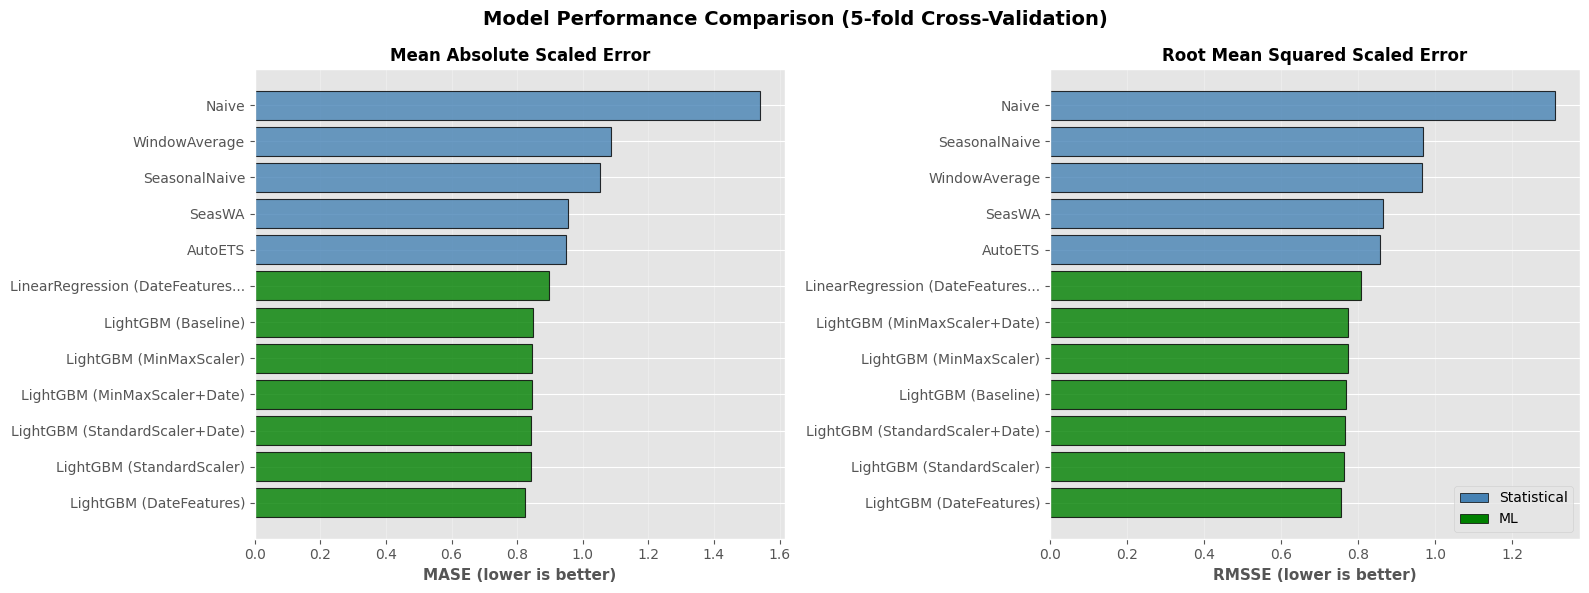

In [ ]:
# Create side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sort by MASE for visualization
comparison_sorted = comparison_df.sort_values('MASE')

# Truncate model names for better display
comparison_sorted['Model_short'] = comparison_sorted['Model'].apply(
    lambda x: x[:30] + '...' if len(x) > 30 else x
)

# Color by type
colors = ['steelblue' if t == 'Statistical' else 'green' 
          for t in comparison_sorted['Type']]

# MASE
axes[0].barh(comparison_sorted['Model_short'], comparison_sorted['MASE'], 
             color=colors, alpha=0.8, edgecolor='black', linewidth=0.8)
axes[0].set_xlabel('MASE (lower is better)', fontsize=11, fontweight='bold')
axes[0].set_title('Mean Absolute Scaled Error', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# RMSSE
comparison_sorted_rmsse = comparison_df.sort_values('RMSSE')
comparison_sorted_rmsse['Model_short'] = comparison_sorted_rmsse['Model'].apply(
    lambda x: x[:30] + '...' if len(x) > 30 else x
)
colors_rmsse = ['steelblue' if t == 'Statistical' else 'green' 
                for t in comparison_sorted_rmsse['Type']]

axes[1].barh(comparison_sorted_rmsse['Model_short'], comparison_sorted_rmsse['RMSSE'], 
             color=colors_rmsse, alpha=0.8, edgecolor='black', linewidth=0.8)
axes[1].set_xlabel('RMSSE (lower is better)', fontsize=11, fontweight='bold')
axes[1].set_title('Root Mean Squared Scaled Error', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', edgecolor='black', label='Statistical'),
    Patch(facecolor='green', edgecolor='black', label='ML')
]
axes[1].legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.suptitle('Model Performance Comparison (5-fold Cross-Validation)', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

### 7.3 Generate Final Forecasts and Visualize

Train the best model on full training data and generate forecasts for test period.

In [ ]:
# Train/Test Split: Same as Session 2 (last 14 days for testing)
test_size = 14
max_date = df['date'].max()
split_date = max_date - pd.Timedelta(days=test_size - 1)

df_train = df[df['date'] < split_date].copy()
df_test = df[df['date'] >= split_date].copy()

print(f"Train/Test Split:")
print("=" * 60)
print(f"Training set: {len(df_train):,} observations")
print(f"Test set: {len(df_test):,} observations")
print(f"\nDate ranges:")
print(f"  Train: {df_train['date'].min()} to {df_train['date'].max()}")
print(f"  Test:  {df_test['date'].min()} to {df_test['date'].max()}")
print(f"\nForecast horizon: {test_size} days")

# Store list
stores = df['unique_id'].unique()
print(f"\nStores: {list(stores)}")

Train/Test Split:
Training set: 59,800 observations
Test set: 700 observations

Date ranges:
  Train: 2013-01-01 00:00:00 to 2016-04-10 00:00:00
  Test:  2016-04-11 00:00:00 to 2016-04-24 00:00:00

Forecast horizon: 14 days

Stores: ['FOODS_1_085', 'FOODS_1_218', 'FOODS_2_128', 'FOODS_2_197', 'FOODS_2_276', 'FOODS_2_360', 'FOODS_3_007', 'FOODS_3_030', 'FOODS_3_080', 'FOODS_3_090', 'FOODS_3_099', 'FOODS_3_120', 'FOODS_3_150', 'FOODS_3_202', 'FOODS_3_226', 'FOODS_3_234', 'FOODS_3_252', 'FOODS_3_281', 'FOODS_3_282', 'FOODS_3_288', 'FOODS_3_295', 'FOODS_3_318', 'FOODS_3_319', 'FOODS_3_329', 'FOODS_3_376', 'FOODS_3_377', 'FOODS_3_389', 'FOODS_3_412', 'FOODS_3_458', 'FOODS_3_462', 'FOODS_3_491', 'FOODS_3_498', 'FOODS_3_501', 'FOODS_3_541', 'FOODS_3_547', 'FOODS_3_555', 'FOODS_3_586', 'FOODS_3_587', 'FOODS_3_607', 'FOODS_3_635', 'FOODS_3_681', 'FOODS_3_694', 'FOODS_3_711', 'FOODS_3_714', 'FOODS_3_723', 'FOODS_3_752', 'FOODS_3_764', 'FOODS_3_804', 'FOODS_3_808', 'FOODS_3_811']


In [ ]:
# Prepare train/test data
df_train_mlf = df_train.rename(columns={'date': 'ds'})
df_test_mlf = df_test.rename(columns={'date': 'ds'})

# Train best model (LightGBM with best configuration)
print(f"Training best model: LightGBM with {best_config_mase}...")

mlf_best = MLForecast(
    models={'LightGBM': lgb.LGBMRegressor(verbose=-1, random_state=42)},
    freq='D',
    lags=list(range(1, optimal_lags + 1)),
    target_transforms=fe_configs[best_config_mase]['target_transforms'],
    date_features=fe_configs[best_config_mase]['date_features']
)

# Fit and predict
mlf_best.fit(df_train_mlf)
forecasts_best = mlf_best.predict(test_size)

# Merge with actual values
forecasts_best = forecasts_best.merge(
    df_test_mlf[['unique_id', 'ds', 'y']], 
    on=['unique_id', 'ds']
)

print("✅ Forecasts generated!")
print(f"\nForecast shape: {forecasts_best.shape}")
forecasts_best.head()

Training best model: LightGBM with DateFeatures...
✅ Forecasts generated!

Forecast shape: (700, 4)


,unique_id,ds,LightGBM,y
0,FOODS_1_085,2016-04-11,69.679500,72
1,FOODS_1_085,2016-04-12,71.245771,69
2,FOODS_1_085,2016-04-13,69.717832,66
3,FOODS_1_085,2016-04-14,67.440532,74
4,FOODS_1_085,2016-04-15,84.890829,89


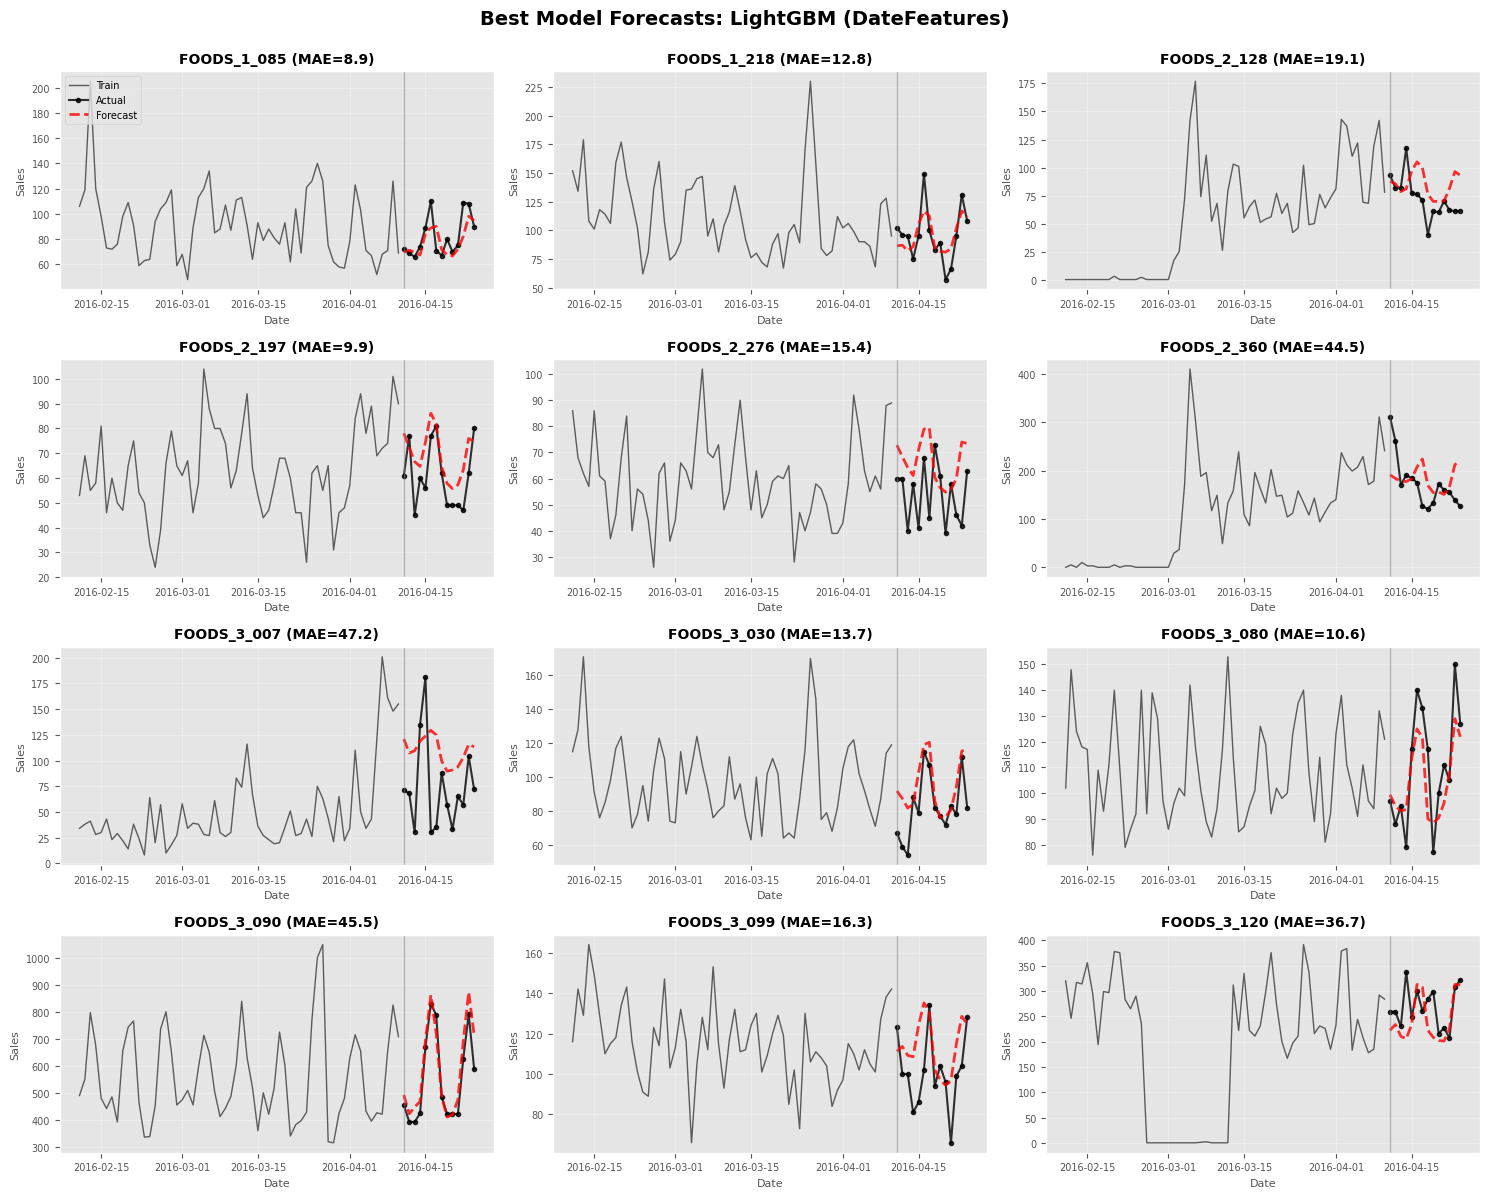

In [ ]:
# Visualize forecasts for a sample of items
sample_items = df['unique_id'].unique()[:12]

fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, item in enumerate(sample_items):
    # Get data
    train_item = df_train_mlf[df_train_mlf['unique_id'] == item].sort_values('ds')
    test_item = df_test_mlf[df_test_mlf['unique_id'] == item].sort_values('ds')
    forecast_item = forecasts_best[forecasts_best['unique_id'] == item].sort_values('ds')
    
    # Plot training data (last 60 days)
    train_context = train_item.tail(60)
    axes[idx].plot(train_context['ds'], train_context['y'], 
                   color='black', linewidth=1, alpha=0.6, label='Train')
    
    # Plot actual test
    axes[idx].plot(test_item['ds'], test_item['y'], 
                   color='black', linewidth=1.5, marker='o', markersize=3,
                   alpha=0.8, label='Actual')
    
    # Plot forecast
    axes[idx].plot(forecast_item['ds'], forecast_item['LightGBM'], 
                   color='red', linewidth=2, linestyle='--', 
                   alpha=0.8, label='Forecast')
    
    # Mark split
    axes[idx].axvline(x=split_date, color='gray', linestyle='-', 
                     linewidth=1, alpha=0.5)
    
    # Calculate error for this item
    mae = mean_absolute_error(forecast_item['y'], forecast_item['LightGBM'])
    
    axes[idx].set_title(f'{item} (MAE={mae:.1f})', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=8)
    axes[idx].set_ylabel('Sales', fontsize=8)
    axes[idx].tick_params(labelsize=7)
    axes[idx].grid(True, alpha=0.3)
    
    if idx == 0:
        axes[idx].legend(fontsize=7, loc='upper left')

plt.suptitle(f'Best Model Forecasts: LightGBM ({best_config_mase})', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 8. Summary and Key Takeaways

### 8.1 What We Accomplished

In this end-to-end notebook, we:

1. **Explored the Data**
   - Visualized time series patterns
   - Decomposed series into trend, seasonality, and residuals
   - Quantified seasonality strength across all items

2. **Evaluated Simple & Statistical Models**
   - Baseline methods: Naive, SeasonalNaive, WindowAverage
   - Statistical model: AutoETS
   - Used 5-fold cross-validation with StatsForecast

3. **Implemented Global ML Models**
   - Performed lag selection via cross-validation
   - Tested multiple feature engineering configurations
   - Compared LightGBM and Linear Regression
   - Used MLForecast for automated feature engineering

4. **Rigorous Evaluation**
   - Defined custom metrics: MASE and RMSSE
   - Performed 5-fold cross-validation
   - Calculated scale-independent metrics

5. **Comprehensive Analysis**
   - Compared all models on common ground
   - Generated forecasts and visualizations
   - Analyzed per-item performance

### 8.2 Key Findings

- **Best Statistical Model**: Seasonal methods (SeasonalNaive, SeasonalWindowAverage) perform well due to strong weekly patterns
- **Best ML Model**: LightGBM with feature engineering (date features + normalization)
- **Feature Engineering Impact**: Significant performance improvement with proper scaling and date features
- **Scale-Independent Metrics**: MASE and RMSSE allow fair comparison across different items

### 8.3 Best Practices Demonstrated

1. **Always Start with EDA** - Understanding patterns guides model selection
2. **Use Baseline Models** - Simple methods provide strong benchmarks
3. **Cross-Validation is Critical** - Ensures robust evaluation
4. **Feature Engineering Matters** - Can dramatically improve performance
5. **Use Scale-Independent Metrics** - Especially for multiple series with different scales
6. **Leverage Modern Libraries** - StatsForecast and MLForecast simplify complex workflows

### 8.4 Next Steps

To further improve forecasts, consider:
- **Hyperparameter tuning** for LightGBM
- **Ensemble methods** combining multiple models
- **External features** (promotions, holidays, weather)

---
